## Exploratory Data Analysis and Feature Grouping 

In [2]:
# Data handling and analysis
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_inline.backend_inline import set_matplotlib_formats

# API requests and date handling
import requests
import io
from datetime import date, timedelta

# Hopsworks platform
import hopsworks

# Configure display settings
%matplotlib inline
set_matplotlib_formats('svg')
sns.set_palette('husl')
plt.rcParams.update({
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 10
})


## Connecting to Hopsworks

In [3]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1133716
2024-10-26 23:13:41,032 WARNING: using legacy validation callback
Connected. Call `.close()` to terminate connection gracefully.


## Extracting Data

In [4]:
# Making a request to access the Earthquake data from USGS (U.S. Geological Survey)
def get_earthquakes_data(date=date.today()):
    params = {
        'format': 'csv',
        'starttime': date - timedelta(days=1),
        'endtime': date
    }

    r = requests.get('https://earthquake.usgs.gov/fdsnws/event/1/query', params=params)
    earthquakes_df = pd.read_csv(io.StringIO(r.text))

    return earthquakes_df

# Filtering the data
def filter_earthquakes_data(df):
    df.dropna(inplace=True)
    df = df[['id', 'time', 'latitude', 'longitude', 'depth', 'depthError', 'rms', 'status', 'type', 'mag']]
    df = df[df.type == 'earthquake']
    df['reviewed'] = (df['status'] == 'reviewed').astype(float)
    df.drop(columns=['type', 'status'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df.rename(columns={'depthError': 'deptherror'}, inplace=True)
    return df

earthquakes_df = pd.concat([filter_earthquakes_data(get_earthquakes_data(date(2024, 10, 25) - timedelta(i))) for i in range(2 * 365)])
earthquakes_df


,id,time,latitude,longitude,depth,deptherror,rms,mag,reviewed
0,mb90064423,2024-10-24T23:44:11.360Z,44.337000,-112.762333,7.050000,1.000000,0.17,1.75,1.0
1,ci40963840,2024-10-24T23:33:59.670Z,36.585333,-117.106500,4.570000,31.610000,0.18,1.74,1.0
2,us7000nn19,2024-10-24T23:28:19.850Z,-16.120800,-173.897500,91.259000,4.345000,0.57,5.40,1.0
3,ci40963824,2024-10-24T23:27:13.620Z,35.653833,-117.469833,7.440000,0.520000,0.15,0.53,0.0
4,ci37686892,2024-10-24T23:23:15.260Z,36.116167,-117.933667,7.490000,1.180000,0.06,0.54,1.0
...,...,...,...,...,...,...,...,...,...
187,nc73799216,2022-10-26T00:34:10.480Z,35.790333,-121.126000,6.240000,0.330000,0.09,1.61,1.0
188,ci40365848,2022-10-26T00:20:59.640Z,32.957167,-115.541000,6.720000,0.590000,0.18,1.31,1.0
189,nc73799211,2022-10-26T00:20:10.600Z,37.316333,-121.681167,7.980000,0.200000,0.07,2.72,1.0
190,tx2022uymn,2022-10-26T00:18:54.999Z,31.659836,-104.321031,7.699756,0.856404,0.20,2.00,1.0


In [5]:
earthquakes_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 167208 entries, 0 to 191
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          167208 non-null  object 
 1   time        167208 non-null  object 
 2   latitude    167208 non-null  float64
 3   longitude   167208 non-null  float64
 4   depth       167208 non-null  float64
 5   deptherror  167208 non-null  float64
 6   rms         167208 non-null  float64
 7   mag         167208 non-null  float64
 8   reviewed    167208 non-null  float64
dtypes: float64(7), object(2)
memory usage: 12.8+ MB


In [6]:
earthquakes_df.describe()

,latitude,longitude,depth,deptherror,rms,mag,reviewed
count,167208.000000,167208.000000,167208.000000,167208.000000,167208.000000,167208.000000,167208.000000
mean,31.147157,-91.532147,23.820071,2.104215,0.243047,1.905733,0.840492
std,19.623138,86.757476,69.124059,3.694508,0.259003,1.459911,0.366150
min,-65.849700,-179.999100,-3.500000,0.080000,0.000000,-1.690000,0.000000
25%,31.367563,-122.816834,2.660000,0.480000,0.070000,0.810000,1.000000
50%,36.151500,-118.272167,7.507609,0.820000,0.150000,1.500000,1.000000
75%,38.837833,-104.198000,12.770000,1.901000,0.300000,2.680000,1.000000
max,86.593900,179.999400,681.238000,99.000000,8.550000,7.800000,1.000000


In [7]:
earthquakes_df.isnull().sum()

id            0
time          0
latitude      0
longitude     0
depth         0
deptherror    0
rms           0
mag           0
reviewed      0
dtype: int64

## EDA

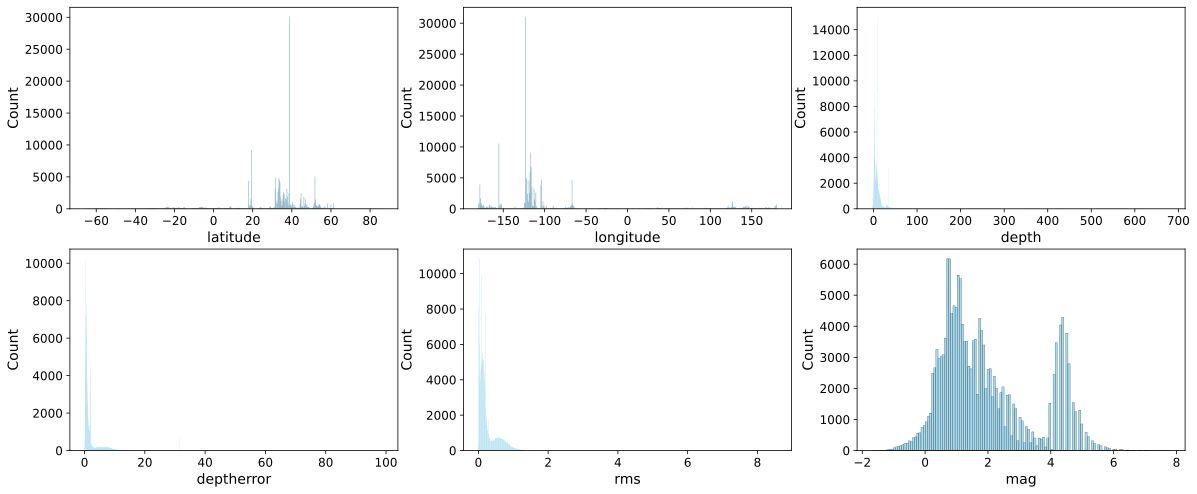

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(20, 8))
for ax, feature in zip(axes.flat, earthquakes_df.columns[2:-1]):
    sns.histplot(earthquakes_df[feature], color='skyblue', ax=ax)
plt.show()

2024-10-26 23:28:17,138 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-10-26 23:28:17,359 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


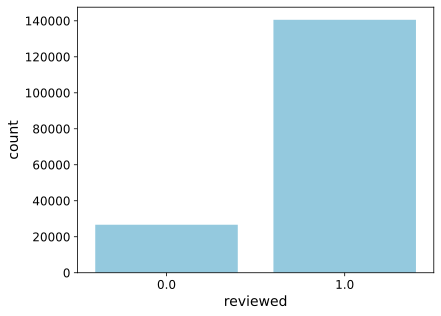

In [9]:
sns.countplot(earthquakes_df, x='reviewed', color='skyblue')
plt.show()

## Feeding the DataFrame into a Feature Group

In [10]:
earthquakes_fg = fs.get_or_create_feature_group(
    name="earthquakes",
    version=1,
    primary_key=['id']
)
earthquakes_fg.insert(earthquakes_df)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1133716/fs/1124419/fg/1318223


Uploading Dataframe: 0.00% |          | Rows 0/167208 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: earthquakes_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1133716/jobs/named/earthquakes_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x1b3dd1f56a0>, None)